In [23]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('future.no_silent_downcasting', True)

In [24]:
chess_king_rook_vs_king = fetch_ucirepo(id=23) 
X = chess_king_rook_vs_king.data.features 
y = chess_king_rook_vs_king.data.targets 

### Przygotowanie danych do pracy

In [25]:
words = {
    'one':1,
    'two':2,
    'three':3,
    'four':4,
    'five':5,
    'six':6,
    'seven':7,
    'eight':8,
    'nine':9,
    'ten':10,
    'eleven':11,
    'twelve':12,
    'thirteen':13,
    'fourteen':14,
    'fifteen':15,
    'sixteen':16,
    'draw':-1,
    'zero':0
}
words['one']

1

In [26]:
X = X.map(lambda x: ord(x) - 96 if isinstance(x, str) else x)
y.loc[:,"white-depth-of-win"] = y.loc[:,"white-depth-of-win"].map(words)

In [27]:
df = pd.merge(X,y,left_index=True, right_index=True)

In [28]:
df["euk"] = np.sqrt(np.square(df["white-king-file"] - df["black-king-file"]) +np.square(df["white-king-rank"] - df["black-king-rank"]) )
df["man"] = np.abs(df["black-king-file"] - df["white-king-file"]) +np.abs(df["black-king-rank"] - df["white-king-rank"])
df["czeb"] = np.maximum(np.abs(df["black-king-file"] - df["white-king-file"]),np.abs(df["black-king-rank"] - df["white-king-rank"]))

In [29]:
dist_rank = np.minimum(df["black-king-rank"] - 1, 8 - df["black-king-rank"])
dist_file = np.minimum(df["black-king-file"] - 1, 8 - df["black-king-file"])

df["dist"] = np.minimum(dist_rank, dist_file)

df.head()

,white-king-file,white-king-rank,white-rook-file,white-rook-rank,black-king-file,black-king-rank,white-depth-of-win,euk,man,czeb,dist
0,1,1,2,3,3,2,-1,2.236068,3,2,1
1,1,1,3,1,3,2,-1,2.236068,3,2,1
2,1,1,3,1,4,1,-1,3.000000,3,3,0
3,1,1,3,1,4,2,-1,3.162278,4,3,1
4,1,1,3,2,3,1,-1,2.000000,2,2,0


### Pytanie 1 [2pkt.]

Gdzie zwykle znajduje się na planszy czarny król, kiedy jest matowany (`white-depth-of-win=0`)? Gdzie znajduje się, kiedy gra kończy się remisem (`white-depth-of-win=-1`)?

In [30]:

def get_matrixlike_df(df, where_is_king):

    col1 = df["black-king-file"].drop_duplicates().sort_values().reset_index(drop=True)
    col2 = df["black-king-rank"].drop_duplicates().sort_values().reset_index(drop=True)

    full_grid = pd.MultiIndex.from_product([col1, col2], names=["black-king-file", "black-king-rank"]).to_frame(index=False)

    heatmap = pd.merge(full_grid, where_is_king, on=["black-king-file", "black-king-rank"], how="left")
    heatmap["count"] = heatmap["count"].fillna(0)

    matrix = heatmap.pivot(index="black-king-rank", columns="black-king-file", values="count").sort_index(ascending=False)
    
    return matrix

In [31]:

where_is_king_mat = df.loc[df["white-depth-of-win"] == 0, :].groupby(["black-king-file","black-king-rank"]).size()\
.reset_index(name='count')
where_is_king_draw = df.loc[df["white-depth-of-win"] == -1, :].groupby(["black-king-file","black-king-rank"]).size()\
.reset_index(name='count')
matrix_mat=get_matrixlike_df(df, where_is_king_mat)
matrix_draw=get_matrixlike_df(df, where_is_king_draw)

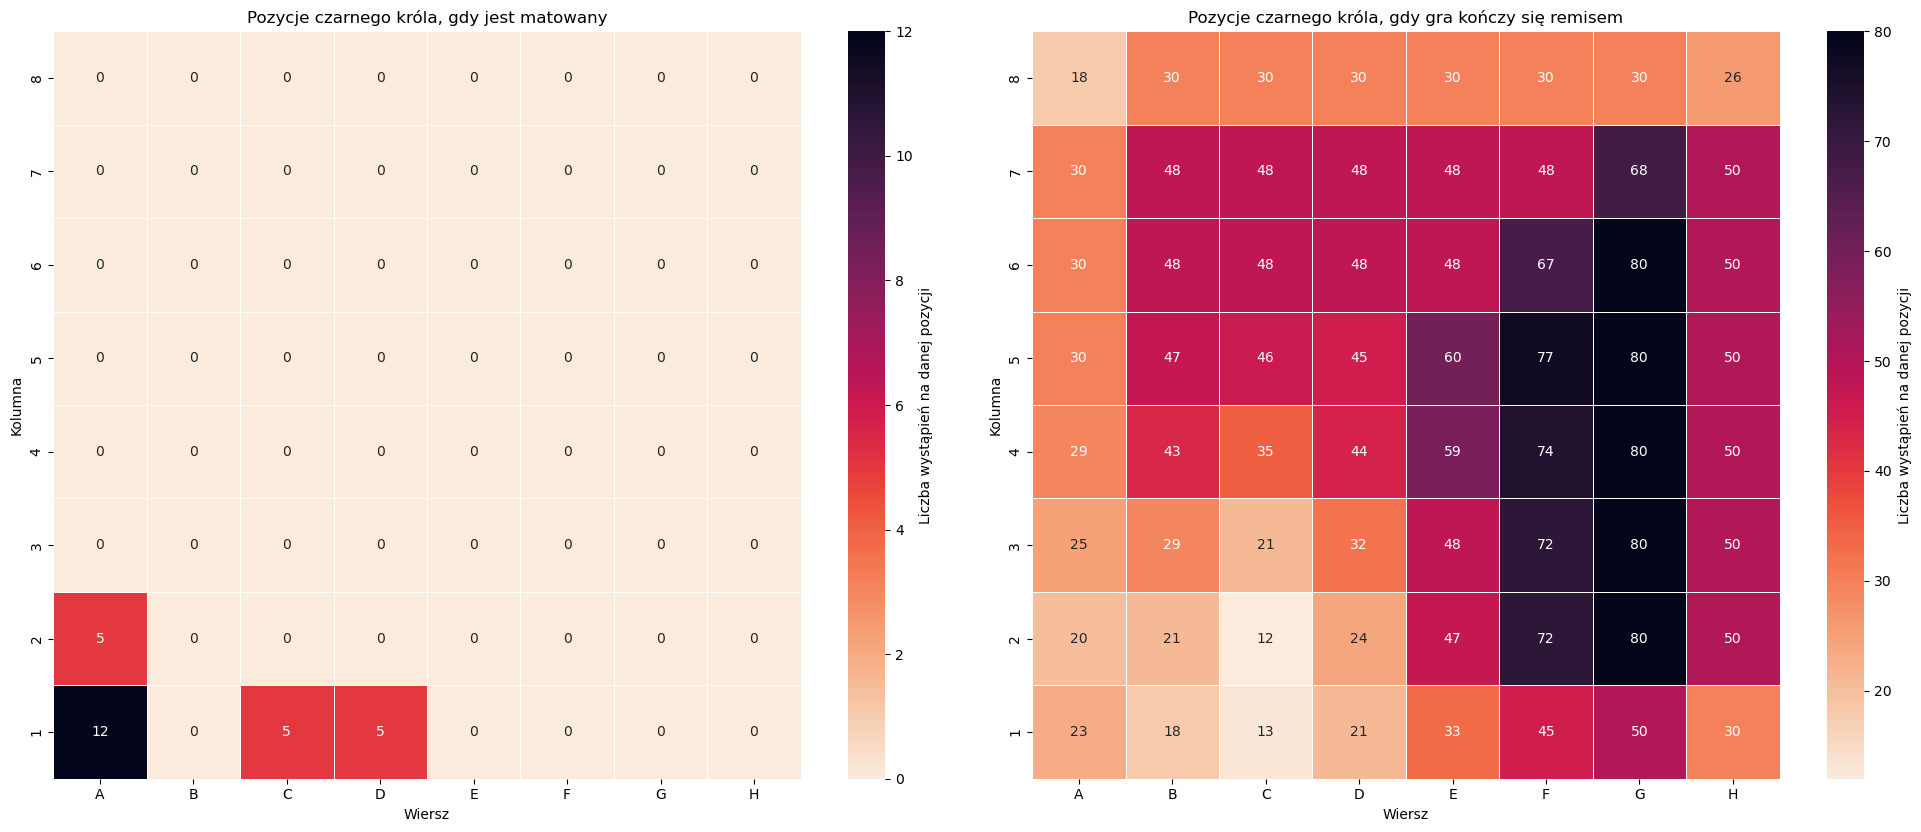

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

columns = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

sns.heatmap(matrix_mat, annot=True, cmap="rocket_r", linewidths=.5, square=True, ax = ax1, 
            cbar_kws={'label': 'Liczba wystąpień na danej pozycji'},
            xticklabels=columns)
ax1.set_title("Pozycje czarnego króla, gdy jest matowany")
ax1.set_xlabel("Wiersz")
ax1.set_ylabel("Kolumna")

sns.heatmap(matrix_draw, annot=True, cmap="rocket_r", linewidths=.5, square=True, ax = ax2, 
            cbar_kws={'label': 'Liczba wystąpień na danej pozycji'},
            xticklabels=columns)
ax2.set_title("Pozycje czarnego króla, gdy gra kończy się remisem")
ax2.set_xlabel("Wiersz")
ax2.set_ylabel("Kolumna")

plt.tight_layout()

### Odpowiedź 1

* W sytuacji, gdy król jest matowany, znajduje się on wyłącznie w rogu i na krawędzi planszy, gdzie komórka **A1** jest jego najczęstszą pozycją. Z jednakową częstością występuje jeszcze na pozycjach **C1**, **D1** oraz **A2**. 

* W sytuacji, gdy gra kończy się remisem, król znajduje się najczęściej po prawej stronie i w środku planszy, w kolumnach **G** i **F** oraz we wierszach **2 - 6**. Każde pole wystąpiło więcej niż 10 razy.

***

### Pytanie 2 [2pkt.]

Jednym z istotnych czynników tego, w ilu ruchach gra się zakończy jest dystans pomiędzy białym królem a czarnym królem. Jaka metryka dystansu (Euklidesowa, Manhattan, lub Czebyszewa) pomiędzy nimi pozwoli najlepiej oszacować liczbę ruchów do zakończenia gry? Do tej analizy zignoruj sytuacje remisowe (`white-depth-of-win = -1`).

In [33]:
df_1 = df.loc[df["white-depth-of-win"]!=-1, :].reset_index(drop=True)
df_1.head()


,white-king-file,white-king-rank,white-rook-file,white-rook-rank,black-king-file,black-king-rank,white-depth-of-win,euk,man,czeb,dist
0,3,1,1,3,1,1,0,2.0,2,2,0
1,3,1,1,4,1,1,0,2.0,2,2,0
2,3,1,1,5,1,1,0,2.0,2,2,0
3,3,1,1,6,1,1,0,2.0,2,2,0
4,3,1,1,7,1,1,0,2.0,2,2,0


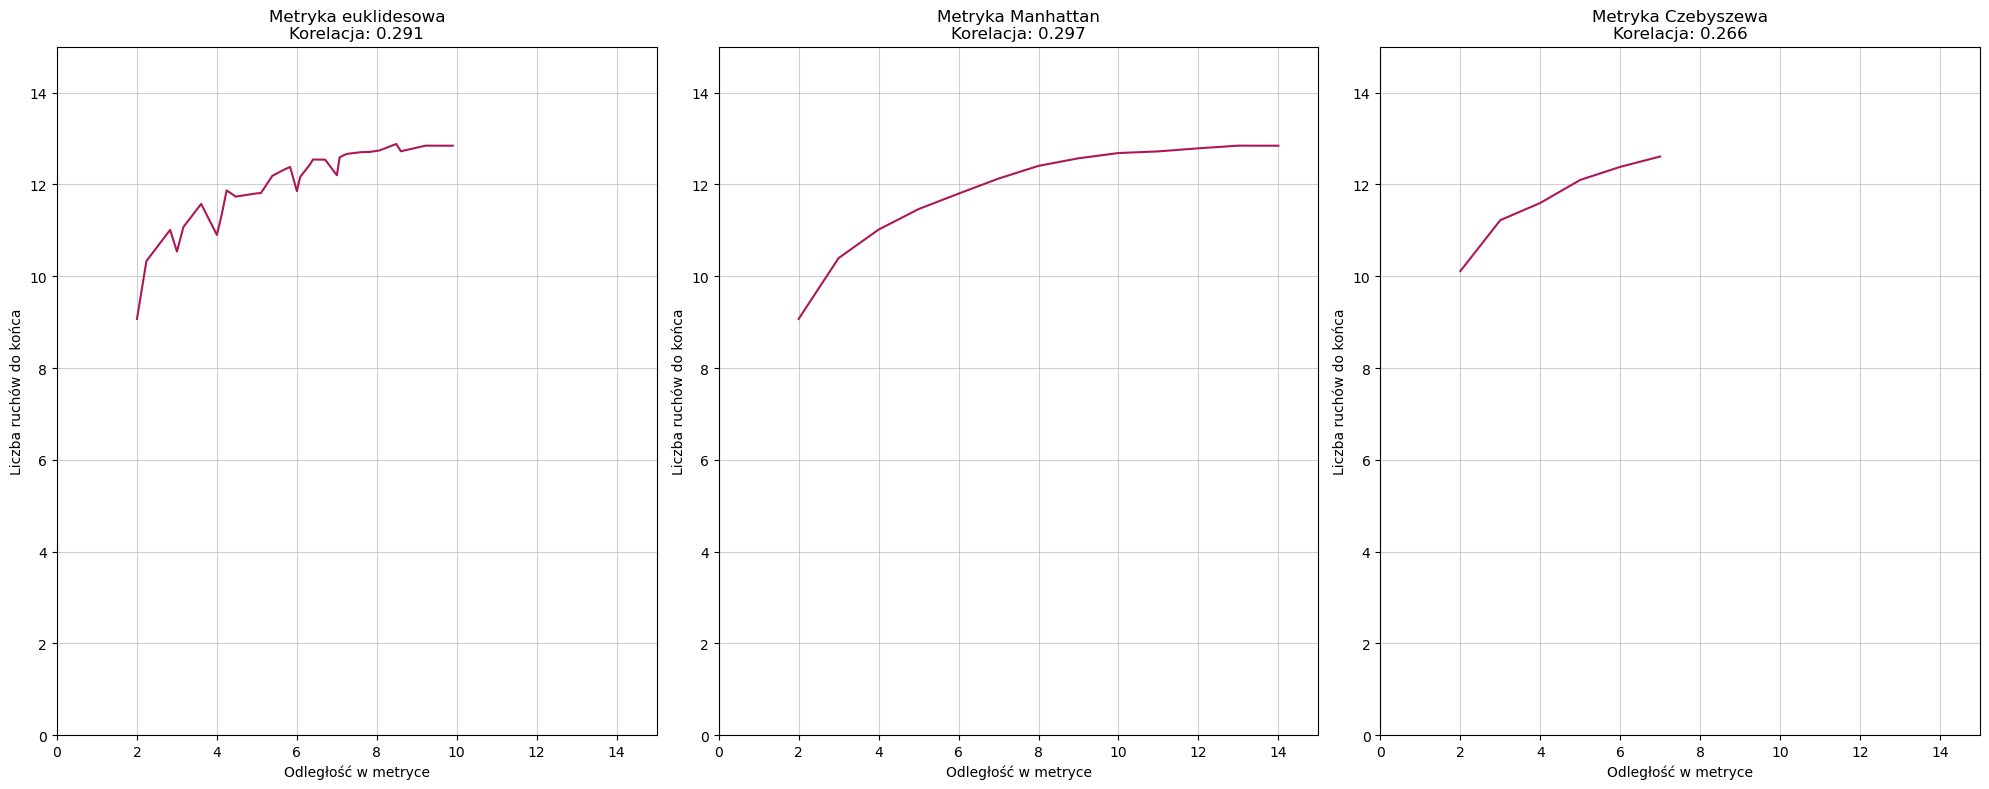

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))

axes = [ax1, ax2, ax3]
metrics = ["euk", "man", "czeb"]
titles = ["Metryka euklidesowa", "Metryka Manhattan", "Metryka Czebyszewa"]

for ax, metric, title in zip(axes, metrics, titles):

    corr= df_1[metric].corr(df_1["white-depth-of-win"])
    sns.lineplot(data=df_1, y="white-depth-of-win", x=metric, ax=ax, color = sns.color_palette("rocket_r")[3], errorbar=None)

    ax.set_title(f"{title}\nKorelacja: {corr:.3f}", fontsize=12)
    ax.set_xlabel("Odległość w metryce")
    ax.set_ylabel("Liczba ruchów do końca")
    
    ax.set_xlim(0, 15)
    ax.set_ylim(0, 15)

    ax.grid(True, alpha = 0.6)
    
plt.tight_layout()

plt.show()


### Odpowiedź 2

Współczynnik korelacji między metryką, a ilością ruchów potrzebnych do zwycięstwa jest największy dla **metryki Manhattan**, co wskazuje, że jest ona najlepsza z podanych trzech do oszacowania liczby ruchów. Widać to również na wykresie, na którym metryka Manhattan osiąga najbardziej stabilny wzrost względem ilości ruchów. Fakt, że metryka ta jest najbardziej podobna do ruchów na planszy szachowej (ruchy wzdłuż linii i kolumn) jest głównym czynnikiem, dlaczego uzykała nawiększy współczynnik korelacji.

***

### Pytanie 3 [2pkt.]

Czy informacja o odległości czarnego króla od krawędzi planszy może być przydatna w określeniu w ilu ruchach zakończy się gra? Czy uzupełnienie tej informacji o odległość pomiędzy białym a czarnym królem z poprzedniego zadania może dodatkowo pomóc? Do tej analizy zignoruj sytuacje remisowe (`white-depth-of-win = -1`).

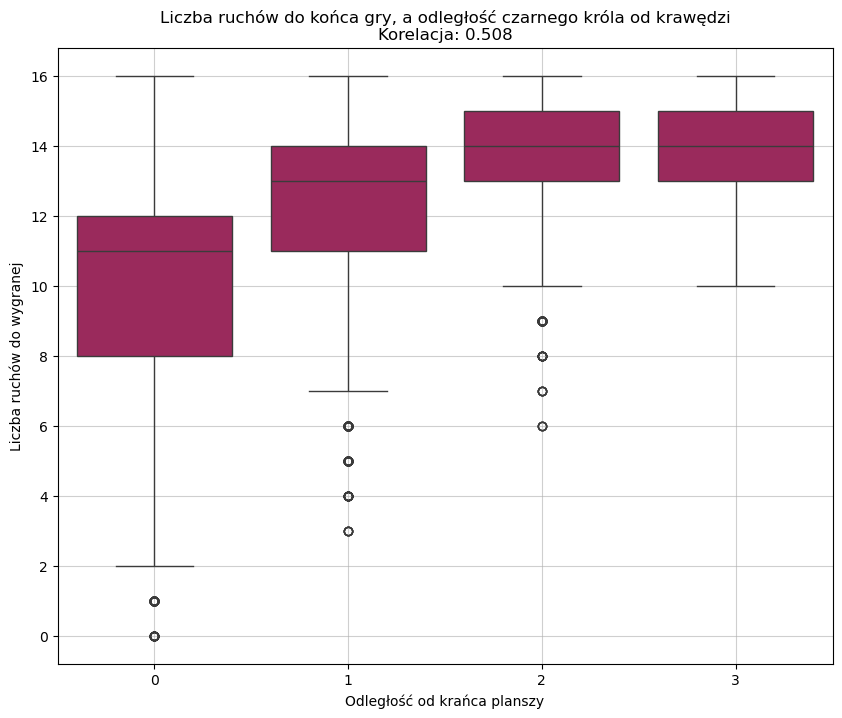

In [35]:
#używamy ramki df_1 z poprzedniego pytania
plt.figure(figsize=(10,8))

corr= df_1["dist"].corr(df_1["white-depth-of-win"])

sns.boxplot(data=df_1, y="white-depth-of-win", x="dist", color = sns.color_palette("rocket_r")[3])

plt.title(f"Liczba ruchów do końca gry, a odległość czarnego króla od krawędzi\nKorelacja: {corr:.3f}", fontsize=12)
plt.xlabel("Odległość od krańca planszy")
plt.ylabel("Liczba ruchów do wygranej")

plt.grid(True, alpha = 0.6)


In [36]:
df["euk"].max()

9.899494936611665

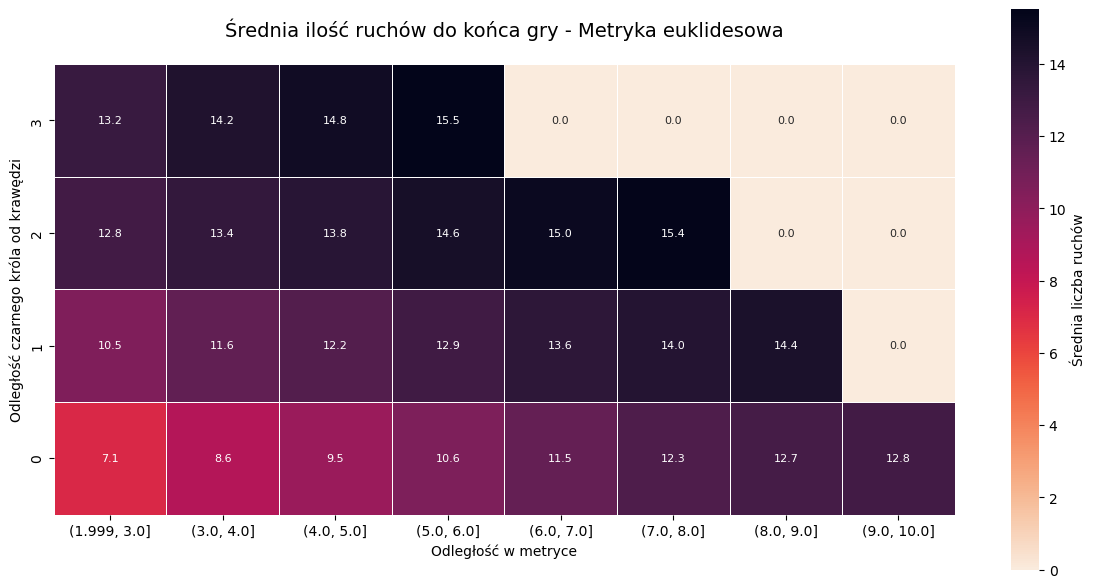

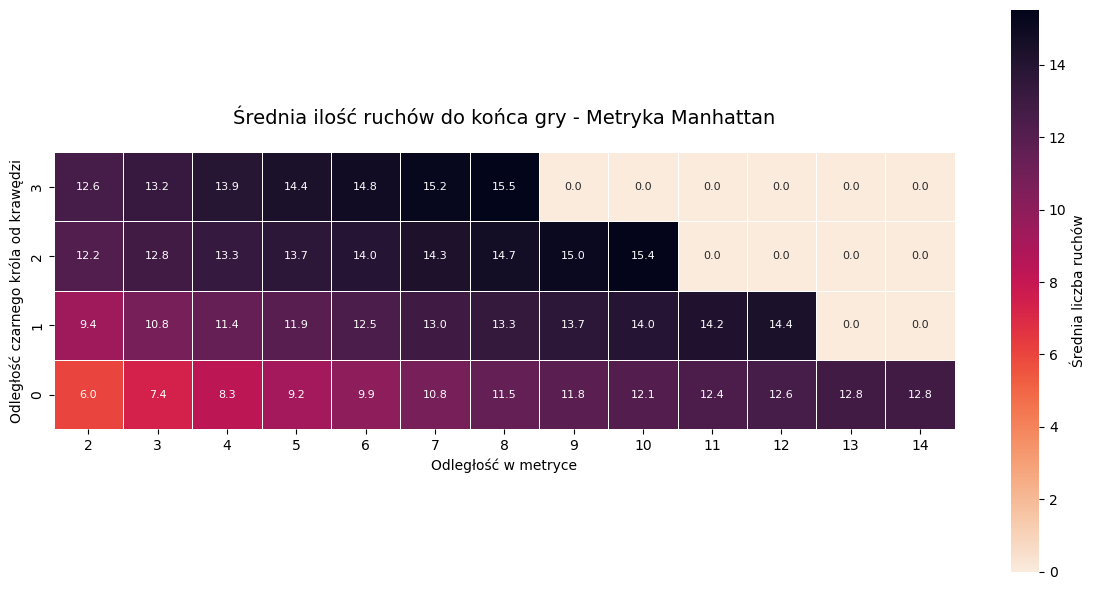

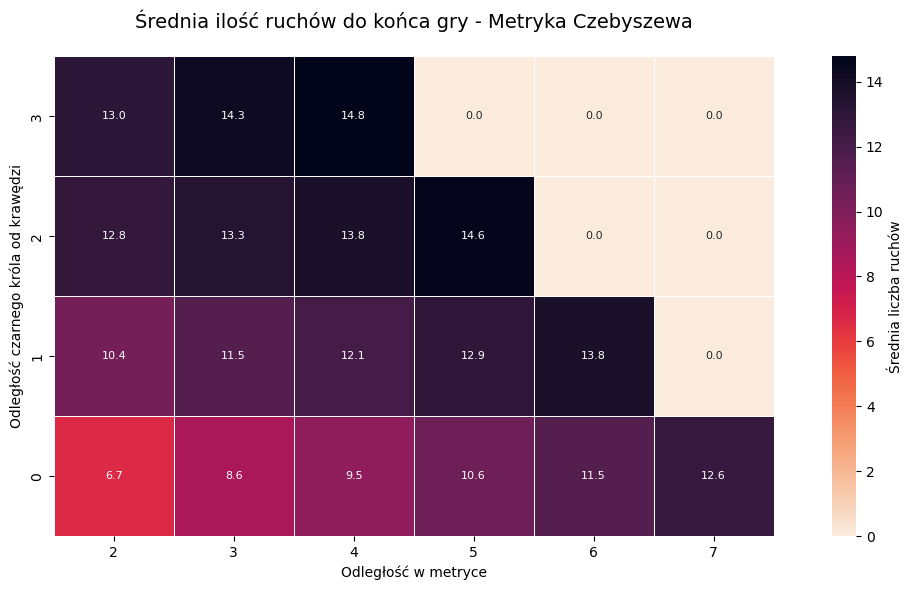

In [22]:
metrics = ["euk", "man", "czeb"]
titles = ["Metryka euklidesowa", "Metryka Manhattan", "Metryka Czebyszewa"]

for metric, title in zip(metrics, titles):

    plt.figure(figsize=(12, 6)) 

    df_1['euk_bins'] = pd.cut(df_1['euk'], bins=range(2, 11), include_lowest=True)
    
    df_2 = (df_1.pivot_table(index="dist",
                             values="white-depth-of-win",
                             columns="euk_bins" if metric == "euk" else metric,
                             aggfunc="mean",
                             observed=False)
            .fillna(0)
            .astype(float)
            .sort_index(ascending=False))
    

    ax = sns.heatmap(df_2, 
                annot=True, 
                fmt=".1f",       
                annot_kws={"size": 8}, 
                cmap="rocket_r", 
                linewidths=.5, 
                square=True,   
                cbar_kws={'label': 'Średnia liczba ruchów'})

    plt.title(f"Średnia ilość ruchów do końca gry - {title}", fontsize=14, pad=20)
    plt.xlabel(f"Odległość w metryce", fontsize=10)
    plt.ylabel("Odległość czarnego króla od krawędzi", fontsize=10)
    
    plt.tight_layout()
    plt.show()


### Odpowiedź 3

* Informacja o odległości czarnego króla od krawędzi planszy zdecydowanie pomaga w określeniu, w ile ruchów zakończy się gra. Współczynnik korelacji między nimi wynosi 0.508 i jest zdecydowanie większy niż dla rozważanych metryk. Wykres pudełkowy pokazuje, że im dalej znajduje się król od krawędzi, tym więcej ruchów potrzeba, aby zakończyć grę.

* Uzupełnienie tej informacji o odległość między czarnym a białym królem również dodatkowo pomaga. Z powyższych map ciepła wynika, że aby gra zakończyła się w jak najmniejszej liczbie ruchów czarny król musi być blisko krawędzi, a biały król musi być blisko czarnego. Nie wystarczy, aby biały król był blisko, tak samo jak nie wystarczy tylko to, że czarny król jest blisko krawędzi. Najwięcej ruchów trzeba wykonać, gdy obaj królowie są daleko i czarny król jest na środku planszy.

